<img src="icon.png" width="50"/> ![Badge](https://img.shields.io/badge/Workshop%20SMLMS%202025-FF1010?style=for-the-badge)
## Single Molecule Tracking and Diffusion

 *[Daniel Sage](mailto:daniel.sage@epfl.ch?subject=Single%20Molecule%20Tracking%20and%20Diffusion), Ecole Polytechnique Fédérale de Lausanne, Switerzland*


In [15]:
import numpy as np
import random
import imageio
import matplotlib.pyplot as plt
import deeptrack as dt
from andi_datasets.models_phenom import models_phenom
from andi_datasets.utils_videos import transform_to_video, play_video
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree


In [2]:
# --- Helpers ----
def compute_msd(traj):
    msd = []
    disp = traj - traj[0]
    msd = np.sum(disp**2, axis=1)
    return msd

def msd_model(t, A):
    return A * t  # A = 4D for 2D Brownian motion

def fit_D(msd):
    time = np.arange(T) * DT
    popt, _ = curve_fit(msd_model, time[1:], msd[1:], p0=(1.0,), maxfev=10000) 
    return popt[0] / 4

def trajectory_features(trajs, dt=1.0):
    """
    Compute features for each trajectory (T, N, 2)
    """
    T, N, _ = trajs.shape
    features = []

    for i in range(N):
        xy = trajs[:,i]  # shape (T, 2)

        # Displacement per frame
        steps = np.diff(xy, axis=0)  # (T-1, 2)
        step_lengths = np.linalg.norm(steps, axis=1)

        # Mean & std of step length
        mean_step = np.mean(step_lengths)
        std_step = np.std(step_lengths)

        # Gaussianity
        gaussianity = (np.mean(step_lengths**4) /
                       (2 * np.mean(step_lengths**2)**2))

        # Straightness index
        net_disp = np.linalg.norm(xy[-1] - xy[0])
        total_path = np.sum(step_lengths)
        straightness = net_disp / total_path if total_path > 0 else np.nan

        # Confinement ratio
        confinement_ratio = np.sqrt(np.mean(np.var(xy, axis=0))) / total_path if total_path > 0 else np.nan

        features.append([mean_step, std_step, gaussianity, straightness, confinement_ratio])

    return np.array(features)

# Classification of Trajectory



### Generating trajectories

Measure 0.934 0.808
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)


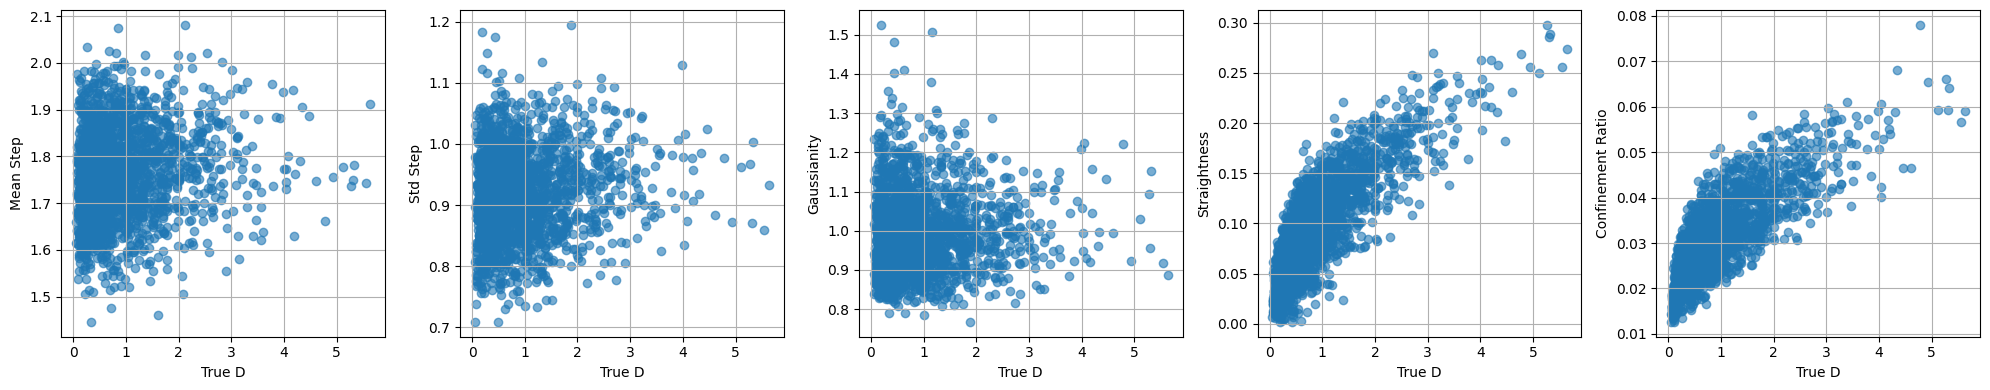

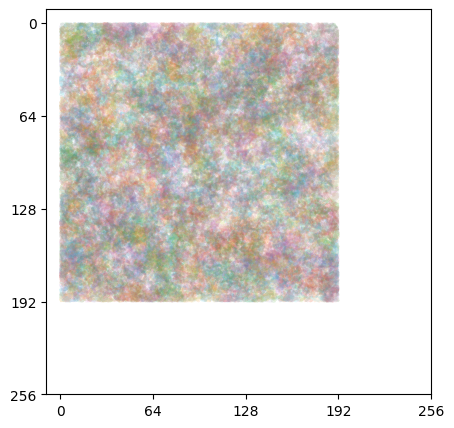

In [10]:
T = 100 # number of time steps (frames)
N = 2000 # number of particles (trajectories)
L = 1.5 * 128 # length of the box (pixels) -> extending fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)
DT = 1

trajs, labels = models_phenom().single_state(N=N, L=L, T=T, alphas=[1, 0], Ds=[1, 0])

D_true = np.zeros(N)
for i in range(N):
    msd = compute_msd(trajs[:,i,:])
    D_true[i] = fit_D(msd)
mean_D = np.mean(D_true)
stdev_D = np.std(D_true)    
print(f'Measure {mean_D:3.3f} {stdev_D:3.3f}')

features = trajectory_features(trajs, dt=DT)
#for i, f in enumerate(features):    print(f"Trajectory {i}: {f}")
    
# Plot 5 scatter plots side-by-side
feature_names = ["Mean Step", "Std Step", "Gaussianity", "Straightness", "Confinement Ratio"]

plt.figure(figsize=(20, 4))
for i in range(5):
    print(D_true.shape, features[:, i].shape)
    plt.subplot(1, 5, i+1)
    plt.scatter(D_true, features[:, i], alpha=0.6)
    plt.xlabel("True D")
    plt.ylabel(feature_names[i])
    plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5))
for i in range(N):
    plt.plot(trajs[:,i,1], trajs[:,i,0], alpha=0.1)
plt.xlim(0, 256)
plt.ylim(0, 256)
plt.axis("square")
ticks = np.arange(0, 257, 64)
plt.xticks(ticks)
plt.yticks(ticks)
plt.gca().invert_yaxis()
plt.show()

### Regression on D (Random Forest)

     Train | R^2:  0.971 | MAE:  0.1006 | RMSE:  0.1404
       Val | R^2:  0.753 | MAE:  0.2786 | RMSE:  0.3943


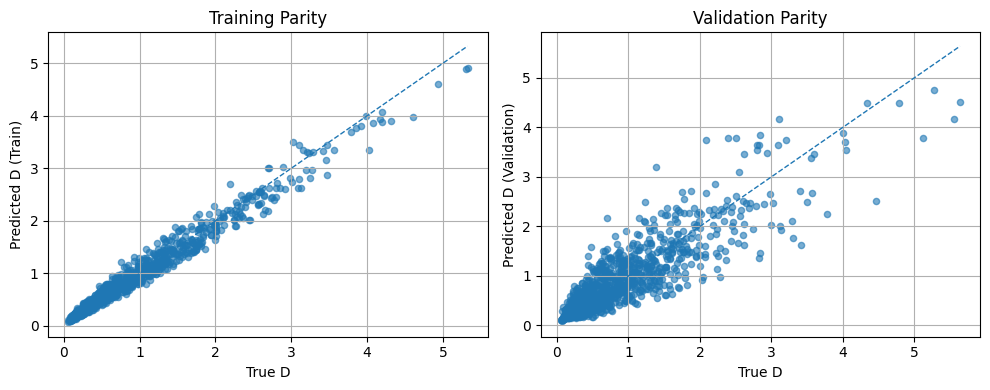

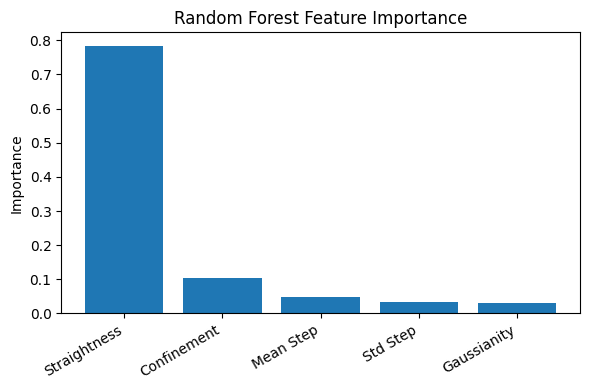

In [20]:
X = features
y = D_true

# 1) Split once: train vs validation (unseen during training)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=1234)

# 2) Train a single Random Forest
rf = RandomForestRegressor(n_estimators=1000, max_depth=None,min_samples_leaf=1,
    random_state=1234, n_jobs=-1, bootstrap=True)
rf.fit(X_train, y_train)

# 3) Evaluate on training and validation splits
def eval_and_print(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # no 'squared' kwarg
    print(f"{name:>10} | R^2: {r2:6.3f} | MAE: {mae:7.4f} | RMSE: {rmse:7.4f}")
    return r2, mae, rmse

y_pred_train = rf.predict(X_train)
y_pred_val   = rf.predict(X_val)

#print(f"OOB R^2 (RF internal estimate): {rf.oob_score_: .3f}")
eval_and_print("Train", y_train, y_pred_train)
eval_and_print("Val",   y_val,   y_pred_val)

# 4) Parity plots (Predicted vs True)
plt.figure(figsize=(10,4))

# Train
plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train, alpha=0.6, s=20)
lims = [min(y_train.min(), y_pred_train.min()), max(y_train.max(), y_pred_train.max())]
plt.plot(lims, lims, '--', linewidth=1)
plt.xlabel("True D")
plt.ylabel("Predicted D (Train)")
plt.title("Training Parity")
plt.grid(True)

# Validation
plt.subplot(1,2,2)
plt.scatter(y_val, y_pred_val, alpha=0.6, s=20)
lims = [min(y_val.min(), y_pred_val.min()), max(y_val.max(), y_pred_val.max())]
plt.plot(lims, lims, '--', linewidth=1)
plt.xlabel("True D")
plt.ylabel("Predicted D (Validation)")
plt.title("Validation Parity")
plt.grid(True)

plt.tight_layout()
plt.show()

# 5) Feature importance (helps interpretability)
importances = rf.feature_importances_
feat_names = ["Mean Step", "Std Step", "Gaussianity", "Straightness", "Confinement"]
order = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.bar(range(len(importances)), importances[order])
plt.xticks(range(len(importances)), [feat_names[i] for i in order], rotation=30, ha='right')
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


|--- Straightness <= 0.15
|   |--- Straightness <= 0.09
|   |   |--- Confinement <= 0.03
|   |   |   |--- Straightness <= 0.05
|   |   |   |   |--- value: [0.24]
|   |   |   |--- Straightness >  0.05
|   |   |   |   |--- value: [0.44]
|   |   |--- Confinement >  0.03
|   |   |   |--- Straightness <= 0.07
|   |   |   |   |--- value: [0.53]
|   |   |   |--- Straightness >  0.07
|   |   |   |   |--- value: [0.77]
|   |--- Straightness >  0.09
|   |   |--- Confinement <= 0.03
|   |   |   |--- Straightness <= 0.13
|   |   |   |   |--- value: [0.72]
|   |   |   |--- Straightness >  0.13
|   |   |   |   |--- value: [1.00]
|   |   |--- Confinement >  0.03
|   |   |   |--- Mean Step <= 1.89
|   |   |   |   |--- value: [1.18]
|   |   |   |--- Mean Step >  1.89
|   |   |   |   |--- value: [1.59]
|--- Straightness >  0.15
|   |--- Straightness <= 0.21
|   |   |--- Straightness <= 0.18
|   |   |   |--- Confinement <= 0.04
|   |   |   |   |--- value: [1.44]
|   |   |   |--- Confinement >  0.04
|   |

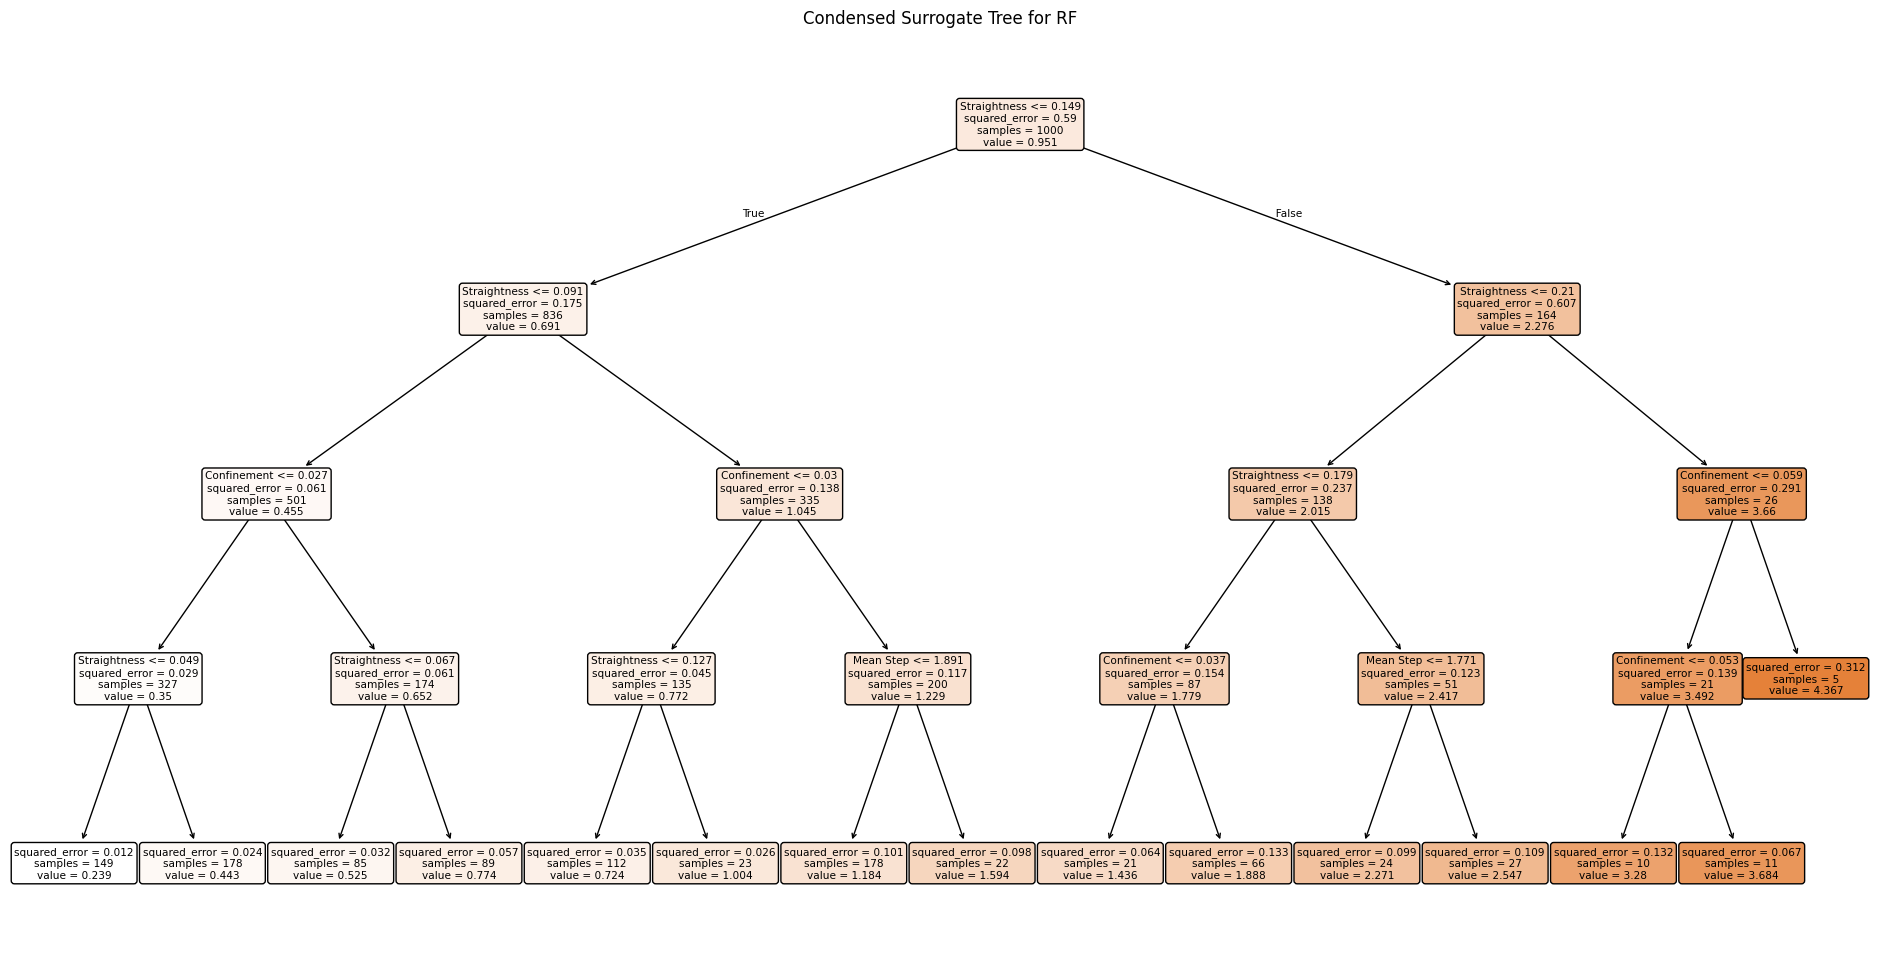

In [17]:
# Step 1: Get RF predictions on the training data
rf_preds_train = rf.predict(X_train)

# Step 2: Fit a small decision tree to mimic the RF
surrogate_tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=1234)
surrogate_tree.fit(X_train, rf_preds_train)

# Step 3: Print readable rules
feature_names = ["Mean Step", "Std Step", "Gaussianity", "Straightness", "Confinement"]
rules_text = export_text(surrogate_tree, feature_names=feature_names)
print(rules_text)

# Step 4: Optional: plot the surrogate tree
plt.figure(figsize=(24, 12))
plot_tree(surrogate_tree,feature_names=feature_names,filled=True,rounded=True)
plt.title("Condensed Surrogate Tree for RF")
plt.show()